<img src = "../../Data/bgsedsc_0.jpg">

# Project: Decision trees and Ensembles

## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree and ensemble models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 10%
+ Data preparation - 15%
+ DT method(s) have been used - 20%
+ Length of stay for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Ensemble models have been used - 10%
+ Complexity of the ensemble - 5% (random forests/boosting are simple ensembles using only trees, stacking is a more complex ensemble model)
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

## Import libraries

In [1]:
# Import libraries 

import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors , KNeighborsRegressor
from sklearn.model_selection import train_test_split
from helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from numpy import sqrt 
import seaborn as sns
import ipywidgets
from math import floor, ceil
import datetime as dt
from datetime import timedelta
 
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pickle
from sklearn.svm import SVC
from datatile.summary.df import DataFrameSummary

# Category encoder
import category_encoders as ce
from category_encoders.woe import WOEEncoder

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,AdaBoostClassifier,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from category_encoders.cat_boost import CatBoostEncoder

from datetime import datetime, timedelta
import time
from keras.models import Sequential
from keras.layers import Dense
import shap

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn import set_config

[MLENS] backend: threading
2023-03-26 01:23:10.197750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 01:23:10.558937: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 01:23:10.577736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-26 01:23:10.577756: I tensorflow/compiler/xla/stream_executor/cuda

## Import data

In [2]:
# Starter code to load data
import pandas as pd
# Training dataset

df_original =pd.read_csv('mimic_train.csv')
df = df_original
df.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [3]:
# Test dataset (to produce predictions)
data_test_original=pd.read_csv('mimic_test_los.csv')
data_test = data_test_original
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [4]:
# Sample output prediction file
pred_sample=pd.read_csv('mimic_kaggle_los_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,LOS
663,200011,3.701046
4608,200044,3.701046
1186,200049,3.701046
1245,200063,3.701046
606,200081,3.701046


In [5]:
# Extra data of all comorbilities:
extra_original =pd.read_csv('MIMIC_diagnoses.csv')
extra = extra_original
extra.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


## Exploratory Data Analysis

In [6]:
#Select categorical variables
cat_col_train=[name for name in df.select_dtypes(exclude=np.number).columns]
num_col_train = [name for name in df.select_dtypes(np.number).columns]
cat_col_test=[name for name in data_test.select_dtypes(exclude=np.number).columns]
num_col_test = [name for name in data_test.select_dtypes(np.number).columns]

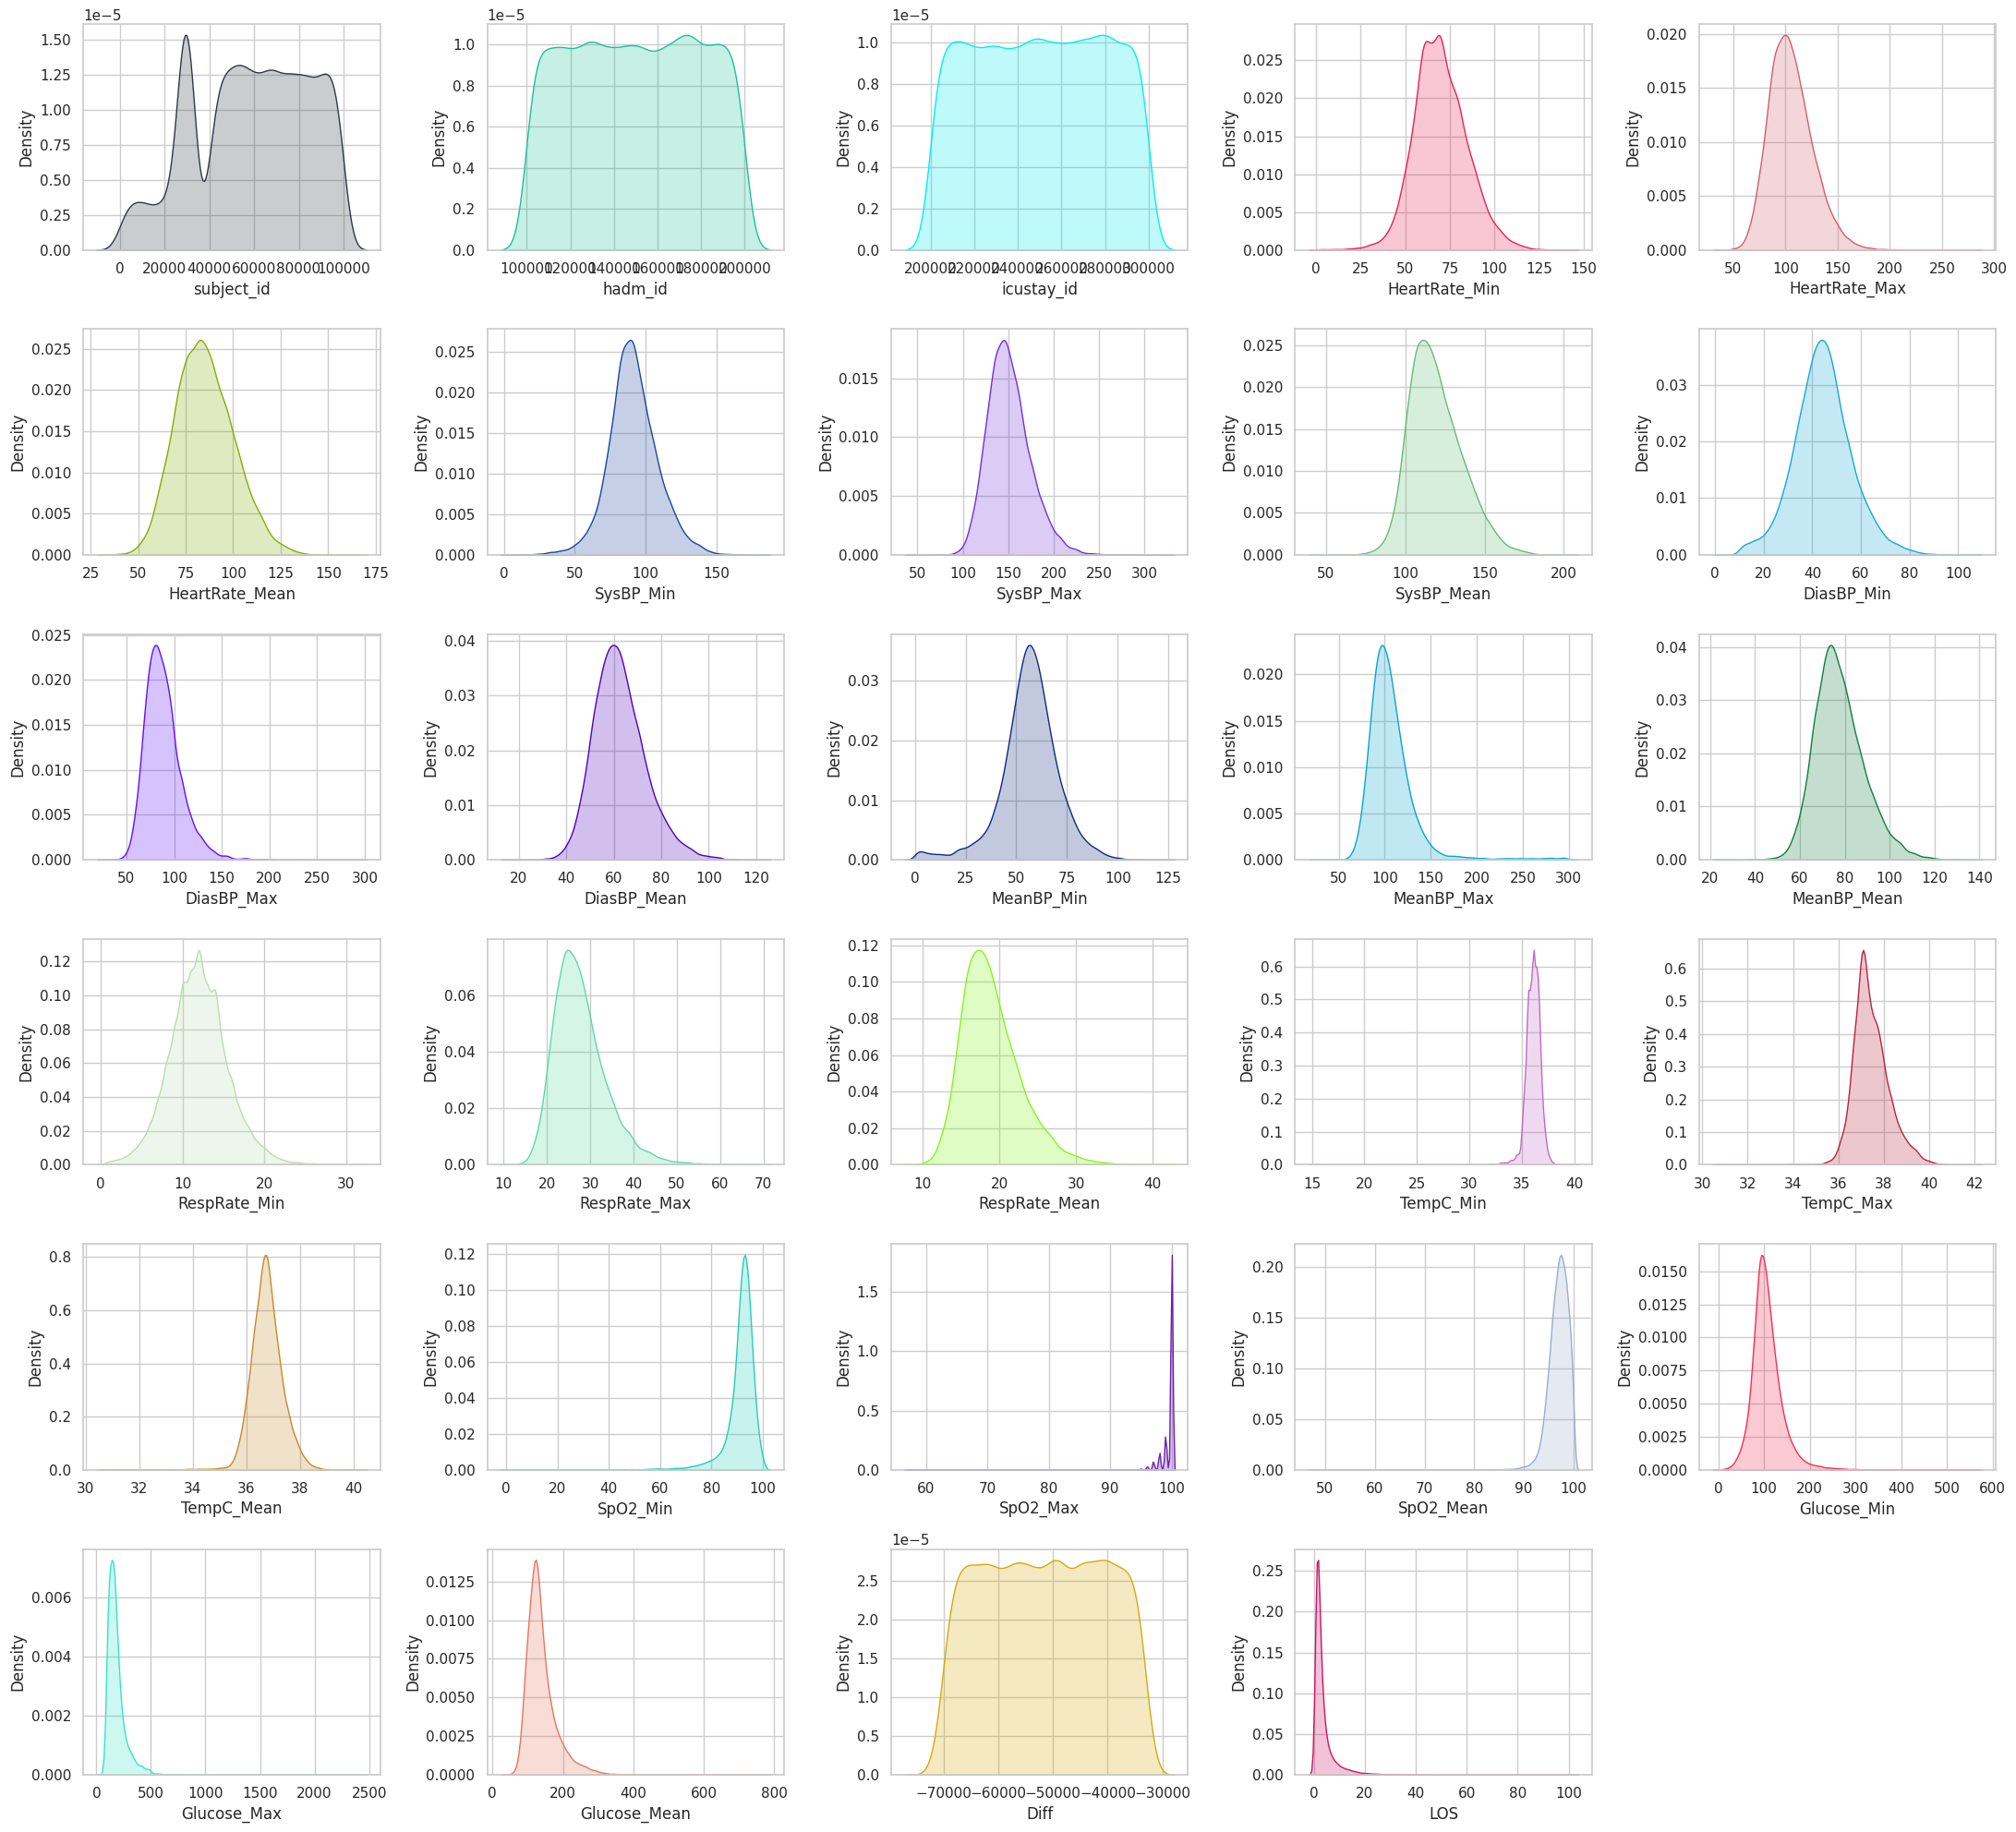

In [7]:
# Univariate kernel density distributions for continuous features
sns.set(style="whitegrid")
plt.figure(figsize=(22, 20)) 

for i, col in enumerate(num_col_train):
  if i == 0:
    pass
  else:
    plt.subplot(6, 5, i) # row, cols and i is the element to plot
    sns.kdeplot(x = col, 
                data = df, 
                fill=True, 
                color = np.random.rand(3,) )
plt.tight_layout()

In [8]:
#Description of continuous variables  
df[num_col_train].describe()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,...,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,...,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,...,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,...,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,...,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,...,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,...,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,...,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000


In [9]:
# Checking levels for each categorical variable in train set
for column in df[cat_col_train]:
    print(f"{column} : {len(df[column].value_counts())}")

GENDER : 2
DOB : 14007
ADMITTIME : 19714
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 17
MARITAL_STATUS : 7
ETHNICITY : 41
DIAGNOSIS : 6193
ICD9_diagnosis : 1853
FIRST_CAREUNIT : 5


## Feature Creation

### Age

+ Create variable Age in data train and data test using DOB and Admittime
+ All the ages over 90 years old (~ 32850 days) are set to more than 300 years old. Acording to  https://mimic.physionet.org/mimicdata/time/ - ages over 89 are shifted such that the patient age appears to be 300 in the database.
+  I will impute them as 90 years old

In [10]:
#Creating AGE variable in data train
df['Diff']=df.apply(lambda x: timedelta(days=-x.Diff),axis=1)
df['DOB'] = df.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
df['DOB'] = df.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
df['ADMITTIME'] = df.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
df['ADMITTIME'] = df.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
df['age']=df.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [11]:
#Creating AGE variable in data test
data_test['Diff']=data_test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
data_test['DOB'] = data_test.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['DOB'] = data_test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
data_test['ADMITTIME'] = data_test.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
data_test['age']=data_test.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [12]:
# Imputation of age
df['age'] = np.where(df['age'] >= 32850, 90, df['age'])
data_test['age'] = np.where(data_test['age'] >= 32850, 90, data_test['age'])

### Comorbilities

+ Create comobilities:  Number of comorbidites in each hospital stay

In [13]:
# Create comobilities:  Number of comorbidites in each hospital stay
num_of_comob=extra['HADM_ID'].value_counts()
df['comob']=df['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)
data_test['comob']=data_test['hadm_id'].replace(to_replace=num_of_comob.index,value=num_of_comob.values)

### Repeat Visits to the ICU

+ Some patients had multiple visits to the intensive care unit
+ It's possible to include this information as a variable. 
+ I will count the amount of times the same subject was admitted into the ICU by grouping the datasets by subject_id and storing the counts into a new variable. 

In [14]:
# Creating new variable that contains the amunt of times a person visited the ICU
df["visits_ICU"] = df.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1
data_test["visits_ICU"] = data_test.sort_values(['subject_id', 'ADMITTIME']).groupby(["subject_id"]).cumcount() + 1

### Probability of death

+ Calculate the probability of death using using the extra dataset considering all the diagnosis of the patients.I used the mean because is just a [0-1] values
+ Then I replace it in the 'IC9-diagnosis'  
+ Replace IC9 diagnosis by probability of death using 'HOSPITAL_EXPIRE_FLAG' of the train set.

In [15]:
alldata = pd.merge(df,extra,how='left',left_on='hadm_id',right_on='HADM_ID')
diag_mean = alldata.groupby('ICD9_CODE').mean()['HOSPITAL_EXPIRE_FLAG']
df['ICD9_diagnosis']=df['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
data_test['ICD9_diagnosis']=data_test['ICD9_diagnosis'].replace(to_replace=diag_mean.index,value=diag_mean.values) #_mean
data_test['ICD9_diagnosis']=pd.to_numeric(data_test['ICD9_diagnosis'])

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [16]:
# Get rid of the columns that are not going to be used anymore.

df=df.drop(['DOB','ADMITTIME','Diff'], axis=1)
data_test=data_test.drop(['DOB','ADMITTIME','Diff'], axis=1)

### Ethnicity

+ I grouped categories with repeat names

In [17]:
df['ETHNICITY'].value_counts()

WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58
WHITE - OT

In [18]:
df['ETHNICITY'] = df['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

df['ETHNICITY'] = df['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

df['ETHNICITY'] = df['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

df['ETHNICITY'] = df['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

df['ETHNICITY'] = df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

df['ETHNICITY'] = df['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')

In [19]:
data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

data_test['ETHNICITY'] = data_test['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')

In [20]:
df['ETHNICITY'].value_counts()

WHITE                   15330
BLACK                    2201
UNKNOWN                  1320
HISPANIC OR LATINO        859
OTHER                     580
ASIAN                     545
MULTI RACE ETHNICITY       50
Name: ETHNICITY, dtype: int64

### Religion

+ I classified religions with few observations in "other" cathegory

In [21]:
df['RELIGION'].value_counts()

CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64

In [22]:
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
df['RELIGION'] = df['RELIGION'].replace(religion_other, 'OTHER')
data_test['RELIGION'] = data_test['RELIGION'].replace(religion_other, 'OTHER')

### Diagnoses

+ We remove the text fields
+ We will target encode (with smoothing) in the pipeline
+ Could do something more complicated aggregating the severity of each diagnosis with comorbidites e.g. max, mean, median ect. but for simplicity I stick to this

In [43]:
df = df.drop(['DIAGNOSIS'], axis = 1)
data_test = data_test.drop(['DIAGNOSIS'], axis = 1)

## Missing Data

+ I will review in general in first place which variables have missing values
+ Marital status is the only categorical value with missing values 

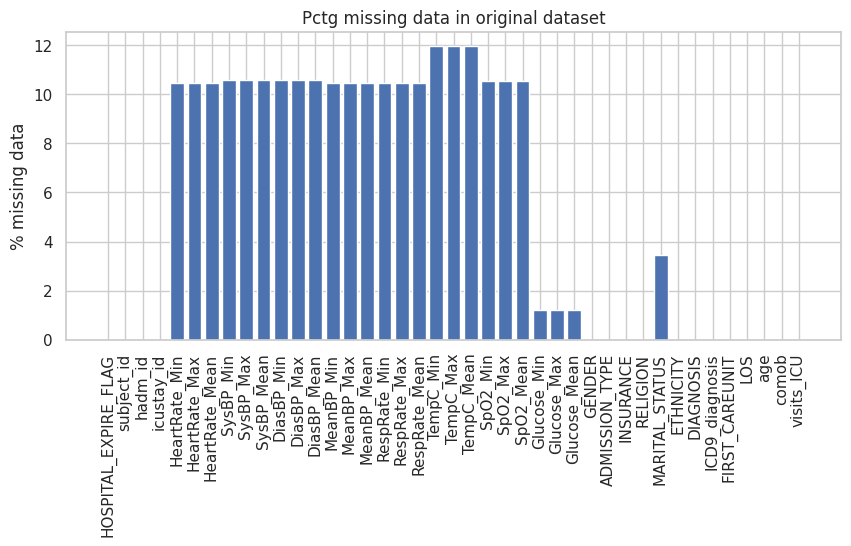

In [23]:
#Missing data in train set

Nulls= df.isnull().sum()
x_vals = Nulls.index
y_vals = 100*Nulls.values/len(df.index)
plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals, y_vals)
plt.ylabel('% missing data')
plt.title('Pctg missing data in original dataset')
plt.show()

### Marital Status

+ There is a category of unknown, so I'll fill the missing values with that category

In [24]:
df['MARITAL_STATUS'].value_counts()

MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: MARITAL_STATUS, dtype: int64

In [25]:
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
data_test['MARITAL_STATUS'] = data_test['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')

## Preprocessing


### kNN imputation 

 + I used KNN imputation with parameters that best performed, with the parameter `add_indicator = true` the performance was better


In [39]:
cont_imputer = KNNImputer(n_neighbors=5, weights = 'uniform', add_indicator=False) #

### Category Encoding 

+ I used the pipeline to encode categorical variables

#### OneHotEncoding/Dummy variables

+ `OneHotEncoder` is a slightly nicer alternative to `pd.get_dummies` 
+ `sparse=False` prevents `OneHotEncoder` from outputting a sparse matrix and allowing comptability later down the pipeline. 

In [40]:
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

### Scaling

+ RobustScaler for the continious variabes 
+ StandardScalar for the discrete ones



In [30]:
cont_scaler = RobustScaler()
cat_scaler = StandardScaler()

Taking care of dropping the ID variables before the pre-process to prevent any leakege of information. In the previous extended assignment I had a problem because I didn't dropped ID related variables before apply my pre-processing

In [44]:
X_train = df.drop(["HOSPITAL_EXPIRE_FLAG",	"subject_id",	"hadm_id",	"icustay_id",'LOS'], axis = 1)
y_train = df["LOS"]
X_test = data_test.drop(["subject_id",	"hadm_id",	"icustay_id"],axis =1)

### Preprocessing Pipeline

I will use the `ColumnTransformer` to allow for different data preprocessing for differen types of columns

+ Numerical values - `RobustScaler()` and `KNNImputer()`
+ Categoricals (not ICD9) - `OneHotEncoder()` and `StandardScaler()`

In [45]:
# Update list of numerical and categorical features
num_feat = X_train.select_dtypes(exclude=['object', 'category']).columns
print(num_feat)

cat_feat = X_train.select_dtypes(include=['object', 'category']).columns
print(cat_feat)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'ICD9_diagnosis', 'age', 'comob', 'visits_ICU'],
      dtype='object')
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')


In [46]:
# pipeline for numerical data
num_preprocessing = make_pipeline(
    cont_scaler,
    cont_imputer   
    )

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    cat_encoder,
    cat_scaler)

# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat),
     ("cat", cat_preprocessing, cat_feat)
     ]
    #,remainder='passthrough'
    , remainder='drop'
)

In [47]:
set_config(display="diagram")
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('knnimputer', KNNImputer())]),
                                 Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'T...
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'ICD9_diagnosis', 'age', 'comob', 'visits_ICU'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object'))])

In [48]:
#Fitting the model
preprocessing.fit(X_train, y_train)
X_train_pp = preprocessing.transform(X_train)

In [49]:
X_train_pp.shape

(20885, 63)

In [50]:
# Extract the fitted transformers
num_pipeline = preprocessing.named_transformers_['num']
cat_pipeline = preprocessing.named_transformers_['cat']

# Extract the encoders from the pipelines
fitted_cat_encoder = cat_pipeline.named_steps['onehotencoder']

# Get feature names from the categorical encoder
cat_columns = fitted_cat_encoder.get_feature_names_out(cat_feat)

# Combine all column names
all_columns = np.concatenate([num_feat, cat_columns])

# Convert the preprocessed data to a DataFrame
X_train_df = pd.DataFrame(X_train_pp, columns=all_columns)

In [52]:
#Applying the preprocessing to the test dataframe

X_test_pp = preprocessing.transform(X_test)
X_test_df = pd.DataFrame(X_test_pp, columns=all_columns)

In [54]:
#Checking common features

print("Features in train data but not in test:")
print(X_train_df.columns.difference(X_test_df.columns) )

print("\nFeatures in test data but not in train:")
print(X_test_df.columns.difference(X_train_df.columns) )

Features in train data but not in test:
Index([], dtype='object')

Features in test data but not in train:
Index([], dtype='object')


## Models

In [90]:
#Define seed 
SEED = 4

#Define X_train and X_test
X_train = X_train_df
X_test = X_test_df

### Naive models

#### Decision Tree

In [56]:
%%time
#Set dfs and target to fit
df, target = X_train, y_train


# Instantiate 
DT_model = DecisionTreeRegressor(criterion = 'squared_error', # 'gini' is default
                                 splitter = 'best', # 'best' is default
                                 min_samples_split = 2, # 2 is default
                                 min_samples_leaf = 1, # 1 is default
                                 min_weight_fraction_leaf = 0, # 0 is default
                                 min_impurity_decrease = 0 # 0 is default
                                 )      

# Fit to data
DT_model.fit(df, target)

CPU times: user 575 ms, sys: 382 µs, total: 576 ms
Wall time: 574 ms


DecisionTreeRegressor(min_impurity_decrease=0, min_weight_fraction_leaf=0)

#### Random Forest

In [57]:
%%time
#Set dfs and target to fit
df, target = X_train, y_train


# Instantiate 
RFC = RandomForestRegressor(n_estimators = 100, # default
                             criterion = 'squared_error', # default
                             min_samples_split = 2, # default
                             min_samples_leaf = 1, # default
                             min_weight_fraction_leaf = 0, # default
                             max_features = 'auto', # default
                             min_impurity_decrease = 0, # default
                             oob_score = False)      # default

# Fit to data
RFC.fit(df, target)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


CPU times: user 34.7 s, sys: 3.46 ms, total: 34.7 s
Wall time: 34.7 s


RandomForestRegressor(max_features='auto', min_impurity_decrease=0,
                      min_weight_fraction_leaf=0)

#### XGboost

In [58]:
%%time

# Set dfs and target to fit
df, target = X_train, y_train

# Instantiate
xgb = xgboost.XGBRegressor()

# Fit to data
xgb.fit(df, target)

CPU times: user 14.4 s, sys: 2.14 ms, total: 14.4 s
Wall time: 1.85 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Feature importance

+ Random Forest model
+ The features with more importance are : 'comob','TempC_Max' and 'ICD9_diagnosis'

In [59]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

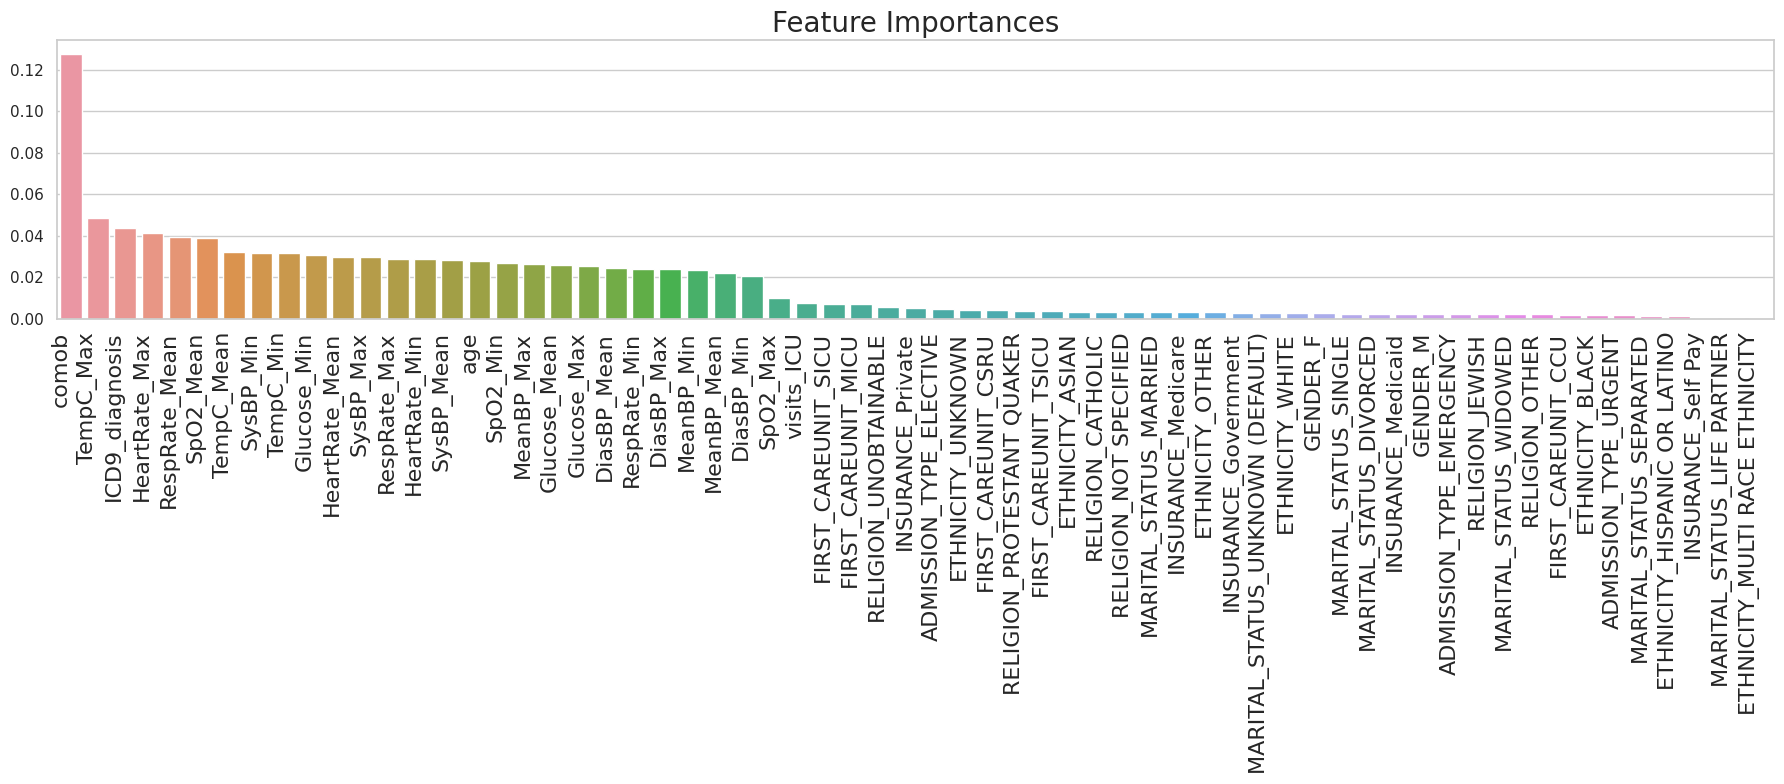

In [60]:
# Save feature names
feature_names = X_train.columns

# Calculate importances 
importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_], axis=0)


#Prepare data and feature names
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)
feat_names = forest_importances.index.to_list()


# Plot importances
plt.figure().set_size_inches(18, 8)

ax = sns.barplot(x = forest_importances.index, 
                 y = forest_importances)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=90, 
                   ha='right',
                   fontsize = 16)
ax.set_title('Feature Importances', fontsize = 20)
plt.tight_layout()
     

### Hiperparameter Tunning

+ Pipeline with 5 possible models
+ Grid search to find the optimal one 
+ I used the mse in the train data as a criterion to select the best possible model

In [61]:
%%time
models = [XGBRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
          GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, 1],
              'max_depth': range(3, 10),
              'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}


dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                      'n_estimators': [50, 100],
                      'max_depth': range(3, 6),
                      'min_samples_leaf': range(5, 10),
                      'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
              'n_estimators': [50, 100],
              'loss':['linear', 'square'],
              'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
              'n_estimators': [50, 100],
              'max_depth': range(3, 6),
              'max_features': range(4, 10),
              'random_state': [SEED]}

params = [xgb_params, dectree_params, randomforest_params , adab_params, gb_params]
names = ['XGB_Regressor', 'DecisionTree_Regressor', 'RandomForest_Regressor','AdaBoost_Regressor','GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = GridSearchCV(model, params[i], n_jobs=-1, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
    y_hat = best_model.predict(X_test)
  

    models[i].set_params(**best_model.best_params_)
    
    scores[names[i]] = (best_model.best_estimator_,-best_model.best_score_)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    print("---------------------------------------------------")

Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 9, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 4}
XGB_Regressor MSE score on train sample: 21.58042525323186
---------------------------------------------------
Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 7, 'random_state': 4}
DecisionTree_Regressor MSE score on train sample: 24.080968773611367
---------------------------------------------------
Grid-Searching for model RandomForest_Regressor...


X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 8, 'n_estimators': 50, 'random_state': 4}
RandomForest_Regressor MSE score on train sample: 23.4071565528592
---------------------------------------------------
Grid-Searching for model AdaBoost_Regressor...


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50, 'random_state': 4}
AdaBoost_Regressor MSE score on train sample: 24.874126277615012
---------------------------------------------------
Grid-Searching for model GradientBoosting_Regressor...


X does not have valid feature names, but AdaBoostRegressor was fitted with feature names


Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 9, 'n_estimators': 100, 'random_state': 4}
GradientBoosting_Regressor MSE score on train sample: 21.79582170527572
---------------------------------------------------
CPU times: user 41.4 s, sys: 516 ms, total: 41.9 s
Wall time: 16min 54s


X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


+ Print the ranking for compare them

In [62]:
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()
ranking.columns = ['Model','Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)
ranking

,Model,Setting,MSE
0,XGB_Regressor,"XGBRegressor(base_score=None, booster=None, ca...",21.580425
1,GradientBoosting_Regressor,([DecisionTreeRegressor(criterion='friedman_ms...,21.795822
2,RandomForest_Regressor,"(DecisionTreeRegressor(max_depth=5, max_featur...",23.407157
3,DecisionTree_Regressor,"DecisionTreeRegressor(max_depth=5, max_feature...",24.080969
4,AdaBoost_Regressor,"(DecisionTreeRegressor(max_depth=3, random_sta...",24.874126


+ Plot ranking

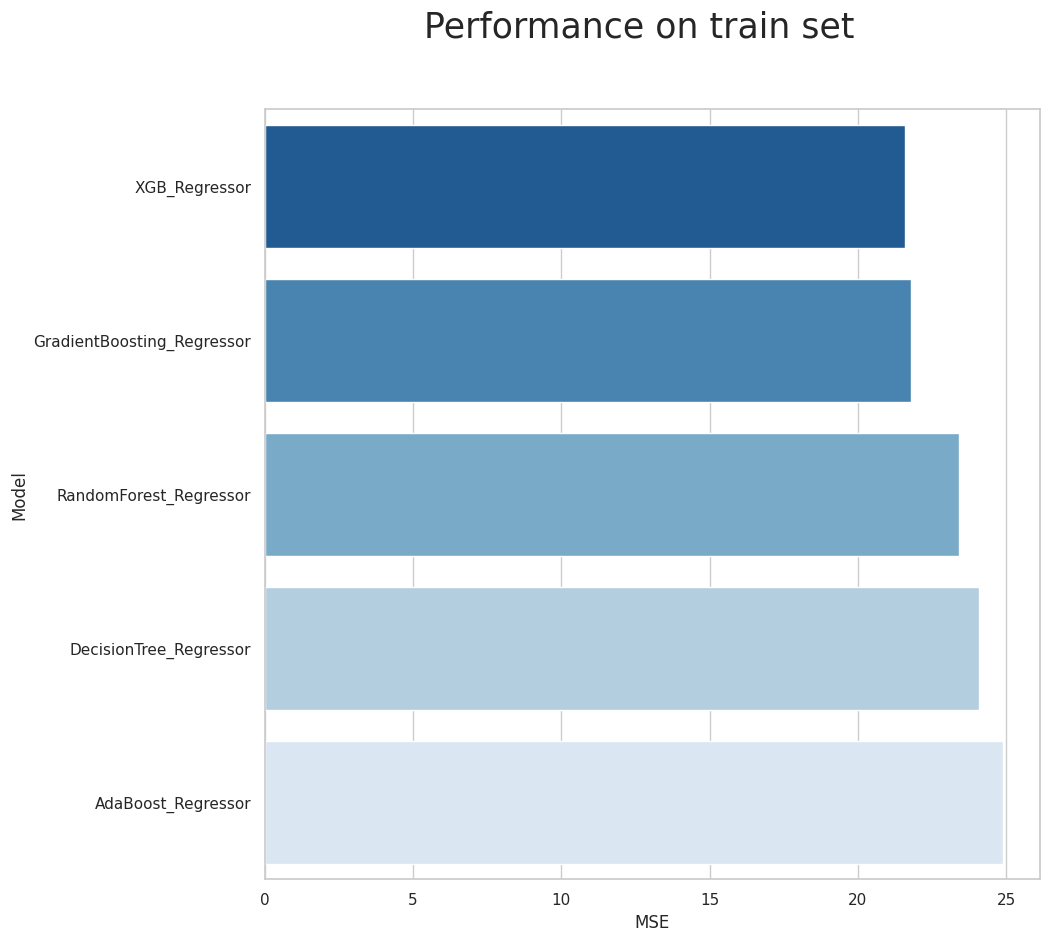

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Performance on train set", fontsize=25)
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

### Ensembles

+ Investigate Metalearner Candidates
+ Fitting three models to train compare to choose the best metalearner for stacking ensemble


In [64]:
from mlens.ensemble import SuperLearner
models = [DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor()]
meta_learners = [
    DecisionTreeRegressor(max_depth= 5, max_features= 9, min_samples_leaf= 6, random_state= SEED),
    RandomForestRegressor(max_depth= 5, max_features= 9, min_samples_leaf= 6, n_estimators= 100, random_state= SEED),
    GradientBoostingRegressor(learning_rate= 0.05, max_depth= 5, max_features= 8, n_estimators= 100, random_state= SEED)
]

meta_learners_ = ['DecisionTrees', 'RandomForest', 'GradientBoosting']

for i, meta_learner in enumerate(meta_learners):
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models, proba=False)
    super_learner.add_meta(meta_learner, proba=False)
    super_learner.fit(X_train, y_train)
    
    cvs = cross_val_score(super_learner, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
    mse = (-1)*cvs.mean()
    scores[f'Stacking{meta_learners_[i]}'] = (super_learner, mse)
    print(f'Super Learner with {meta_learners_[i]} MSE: {mse}')

Super Learner with DecisionTrees MSE: 22.287252726997263
Super Learner with RandomForest MSE: 21.808908713677873
Super Learner with GradientBoosting MSE: 22.329593981569737


In [65]:
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()
ranking.columns = ['Model','Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)
ranking

,Model,Setting,MSE
0,XGB_Regressor,"XGBRegressor(base_score=None, booster=None, ca...",21.580425
1,GradientBoosting_Regressor,([DecisionTreeRegressor(criterion='friedman_ms...,21.795822
2,StackingRandomForest,"SuperLearner(array_check=None, backend=None, f...",21.808909
3,StackingDecisionTrees,"SuperLearner(array_check=None, backend=None, f...",22.287253
4,StackingGradientBoosting,"SuperLearner(array_check=None, backend=None, f...",22.329594
5,RandomForest_Regressor,"(DecisionTreeRegressor(max_depth=5, max_featur...",23.407157
6,DecisionTree_Regressor,"DecisionTreeRegressor(max_depth=5, max_feature...",24.080969
7,AdaBoost_Regressor,"(DecisionTreeRegressor(max_depth=3, random_sta...",24.874126


#### Stacked Generalization with Feature Propagation 

In [66]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [67]:
features_d = X_train.columns

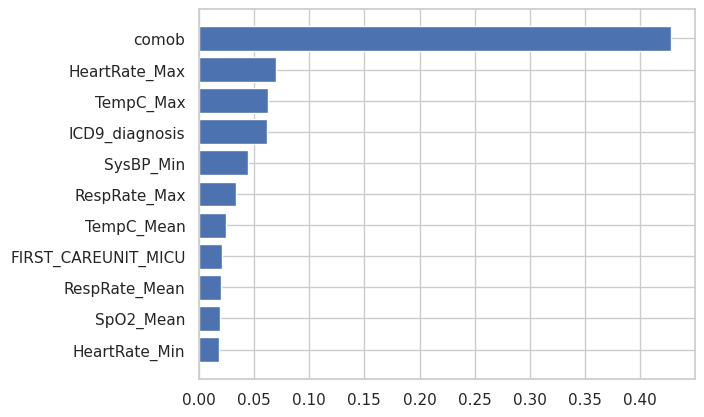

In [68]:
xgb_opt = models[-1].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), features_d)

In [69]:
feat_to_prop = [features_d[i] for i in feat_indexes_xgb][-5:]
pointer = [i for i, feat in enumerate(features_d) if feat in feat_to_prop]
X_train.columns[pointer]

Index(['HeartRate_Max', 'SysBP_Min', 'TempC_Max', 'ICD9_diagnosis', 'comob'], dtype='object')

+ This part of the model I couldn't run it properly so I will comment it

In [ ]:
# for i, meta_learner in enumerate(meta_learners):
#     print(f'\nStackingPropagating {meta_learners_[i]}')
#     super_learner = SuperLearner(folds=5, random_state=SEED)

#     super_learner.add(models, propagate_features=pointer, proba=False)
#     super_learner.add_meta(meta_learner, proba=False)
#     #super_learner.fit(X_train.values, y_train)
#     super_learner.fit(X_train, y_train)
    
#     #y_pred = super_learner.predict(X_train)
#     #mse = mean_squared_error(y_train, y_pred)
#     cvs = cross_val_score(super_learner, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
#     mse = (-1)*cvs.mean()
    
#     print(f'Super Learner with {meta_learners_[i]} MSE: {mse}')


### Neural Networks

+ Now I will run an initial neural network model
+ Sequential constructor takes an array of keras Layers
+ Define a range of Number of epochs (the number of times the learning algorithm will work through the whole dataset)


In [73]:
input_shape = X_train.shape[1]
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(Dense(1, activation='linear'))

# Define the range of epochs to try
epochs_list = range(10, 91, 5)

# Create empty lists to store the MSE values and corresponding epoch values
mse_list = []
epoch_list = []

# Loop over the range of epochs and train the model for each epoch value
for i in epochs_list:
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    model.fit(X_train, y_train, epochs=i, batch_size=32, validation_split=0.2)
    
    # Make predictions using the trained model
    y_pred = model.predict(X_train)
    
    # Calculate the MSE and store it in the list
    mse = mean_squared_error(y_train, y_pred)
    mse_list.append(mse)
    epoch_list.append(i)

Epoch 1/10
523/523 [==============================] - 1s 2ms/step - loss: 25.4014 - mean_squared_error: 25.4014 - val_loss: 25.5268 - val_mean_squared_error: 25.5268
Epoch 2/10
523/523 [==============================] - 1s 2ms/step - loss: 21.6436 - mean_squared_error: 21.6436 - val_loss: 24.8327 - val_mean_squared_error: 24.8327
Epoch 3/10
523/523 [==============================] - 1s 2ms/step - loss: 21.0344 - mean_squared_error: 21.0344 - val_loss: 24.7059 - val_mean_squared_error: 24.7059
Epoch 4/10
523/523 [==============================] - 1s 2ms/step - loss: 20.6844 - mean_squared_error: 20.6844 - val_loss: 24.5277 - val_mean_squared_error: 24.5277
Epoch 5/10
523/523 [==============================] - 1s 2ms/step - loss: 20.4239 - mean_squared_error: 20.4239 - val_loss: 24.4454 - val_mean_squared_error: 24.4454
Epoch 6/10
523/523 [==============================] - 1s 2ms/step - loss: 20.2210 - mean_squared_error: 20.2210 - val_loss: 24.4627 - val_mean_squared_error: 24.4627
Epoc

+ Find the minimun MSE value

Minimum MSE: 16.24040927343001 - Epoch: 90


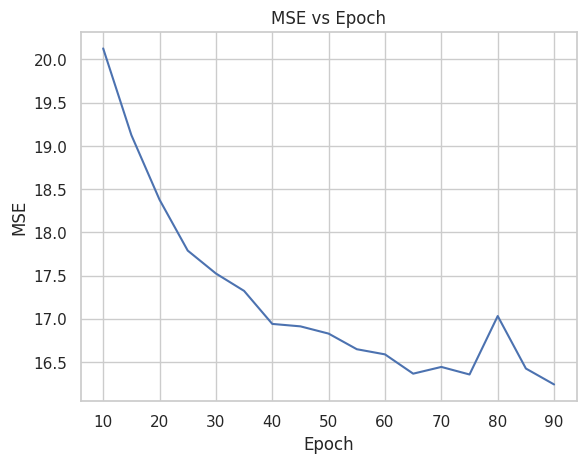

In [74]:
# Find the index of the minimum MSE value
min_mse_index = mse_list.index(min(mse_list))
scores['Neural Network_Relu'] = ('-',mse_list[min_mse_index])
# Print the minimum MSE value and corresponding epoch value
print('Minimum MSE:', mse_list[min_mse_index], '- Epoch:', epoch_list[min_mse_index])

# Create a plot to visualize the relationship between MSE and epoch
plt.plot(epoch_list, mse_list)
plt.title('MSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

+ Improvements to the neural network
+ I will try different activation function and optimizer to see if MSE decrease

In [75]:
# Define model with different activation function
# Define model with different activation function
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(input_shape,)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='linear'))

# Compile the model with different optimizer
optimizer = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train the model for different numbers of epochs
epochs = range(10, 91, 5)
epoch_list = []
mse_list = []
for epoch in epochs:
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, verbose=0)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    mse_list.append(mse)
    epoch_list.append(epoch)
    print(f"Epoch {epoch} - Validation MSE: {mse}")


The `lr` argument is deprecated, use `learning_rate` instead.


653/653 [==============================] - 1s 1ms/step
Epoch 10 - Validation MSE: 28.35896327972187
653/653 [==============================] - 1s 1ms/step
Epoch 15 - Validation MSE: 19.886862856895146
653/653 [==============================] - 1s 1ms/step
Epoch 20 - Validation MSE: 22.55253664684172
653/653 [==============================] - 1s 1ms/step
Epoch 25 - Validation MSE: 21.470275022713345
653/653 [==============================] - 1s 1ms/step
Epoch 30 - Validation MSE: 23.098072849891356
653/653 [==============================] - 1s 1ms/step
Epoch 35 - Validation MSE: 20.707056931848705
653/653 [==============================] - 1s 1ms/step
Epoch 40 - Validation MSE: 21.55524958663803
653/653 [==============================] - 1s 1ms/step
Epoch 45 - Validation MSE: 22.26362225016986
653/653 [==============================] - 1s 1ms/step
Epoch 50 - Validation MSE: 21.924365182664417
653/653 [==============================] - 1s 1ms/step
Epoch 55 - Validation MSE: 28.3274168011

+ Find the minimun MSE value

Minimum MSE: 19.886862856895146 - Epoch: 15


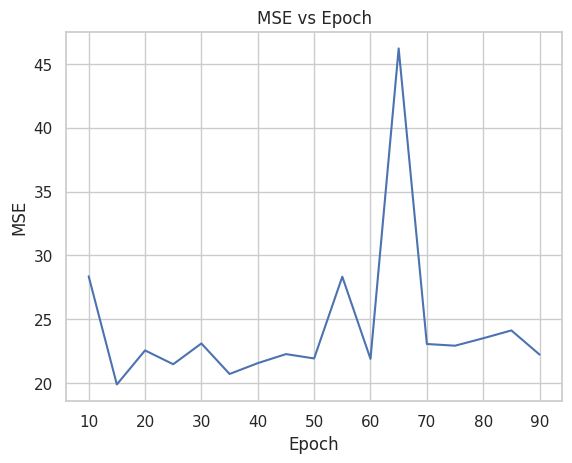

In [76]:
# Find the index of the minimum MSE value
min_mse_index = mse_list.index(min(mse_list))
if mse_list[min_mse_index]< 50:
    scores['Neural Network_Sig'] = ('-',mse_list[min_mse_index])
# Print the minimum MSE value and corresponding epoch value
print('Minimum MSE:', mse_list[min_mse_index], '- Epoch:', epoch_list[min_mse_index])

# Create a plot to visualize the relationship between MSE and epoch
plt.plot(epoch_list, mse_list)
plt.title('MSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

+ Did not work out, the MSE is higher

### Best Model

+ It's possible to see that the best model is the XGBRegressor acording to the MSE

In [77]:
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()
ranking.columns = ['Model','Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)
ranking

,Model,Setting,MSE
0,Neural Network_Relu,-,16.240409
1,Neural Network_Sig,-,19.886863
2,XGB_Regressor,"XGBRegressor(base_score=None, booster=None, ca...",21.580425
3,GradientBoosting_Regressor,([DecisionTreeRegressor(criterion='friedman_ms...,21.795822
4,StackingRandomForest,"SuperLearner(array_check=None, backend=None, f...",21.808909
5,StackingDecisionTrees,"SuperLearner(array_check=None, backend=None, f...",22.287253
6,StackingGradientBoosting,"SuperLearner(array_check=None, backend=None, f...",22.329594
7,RandomForest_Regressor,"(DecisionTreeRegressor(max_depth=5, max_featur...",23.407157
8,DecisionTree_Regressor,"DecisionTreeRegressor(max_depth=5, max_feature...",24.080969
9,AdaBoost_Regressor,"(DecisionTreeRegressor(max_depth=3, random_sta...",24.874126


+ The MSE could not be obtain by cross validation in the neural networks
+ I changed the preprocessing but the MSE got worse after it
+ The model with the best results was the XGB_Regressor so it's the model that I uploaded in the competition and it's the model that I would save here and use it for the model interpretability

In [78]:
# Fit the best model for the objective
mod = 2
selected_model = ranking.Setting[mod].fit(X_train, y_train)
selected_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [79]:
best_mse = str(round(ranking['MSE'][mod],3))
best_mod = ranking['Model'][mod]

## Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "icustay_id"'s and the other with your predicted "LOS" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

#### Simple models

In [80]:
#Decision tree
# Probability prediction
p_hat_test = DT_model.predict(X_test)
p_hat_test = pd.Series(p_hat_test)

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test_original["icustay_id"], "LOS": p_hat_test})

#test_predictions_submit.to_csv(path + "prep_preds/DT-preds_submit.csv", index = False)
test_predictions_submit.to_csv("test_predictions_submit_decision_tree_VicenteLisboa.csv", index = False)

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


In [81]:
# Random Forest
p_hat_test = RFC.predict(X_test)
p_hat_test = pd.Series(p_hat_test)

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test_original["icustay_id"], "LOS": p_hat_test})
#test_predictions_submit.to_csv(path + "prep_preds/RF-preds_submit.csv", index = False)
test_predictions_submit.to_csv("test_predictions_submit_random_forest_VicenteLisboa.csv", index = False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [82]:
# XGB boost
p_hat_test = xgb.predict(X_test)
p_hat_test = pd.Series(p_hat_test)


# Date for filename
date_filename = str(datetime.now().strftime('%Y_%m_%d_%H_%M'))

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test_original["icustay_id"], "LOS": p_hat_test})
#test_predictions_submit.to_csv(path + "prep_preds/grad_boo-preds_submit.csv", index = False)
test_predictions_submit.to_csv('test_predictions_submit_xgboost_VicenteLisboa' + date_filename + '.csv', index = False)

#### Best model

In [83]:
# Grid search prediction
y_pred = selected_model.predict(X_test)
y_pred
y_hat_test= pd.Series(y_pred)
y_hat_test

# Date for filename
date_filename = str(datetime.now().strftime('%Y_%m_%d_%H_%M'))

# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test_original["icustay_id"], "LOS": y_hat_test})
test_predictions_submit.to_csv('test_predictions_submit_best_model_VicenteLisboa_'+ best_mod +'-'+ best_mse+ '-'+ date_filename + '.csv', index = False)

## Model interpretability

+ I will use Python's shap package
+ The idea is to find a feature’s marginal contribution to the overall prediction by looking at the prediction with or without this predictor
+ I will use it the selected model

In [84]:
selected_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [91]:
#Model with best performance according what we defined
Xgb = XGBRegressor(learning_rate= 0.05, max_depth= 7, min_child_weight= 6, objective = "reg:squarederror", reg_lambda= 1.5, seed= 4)
Xgb.fit(X_train, y_train)
y_hat= Xgb.predict(X_test)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


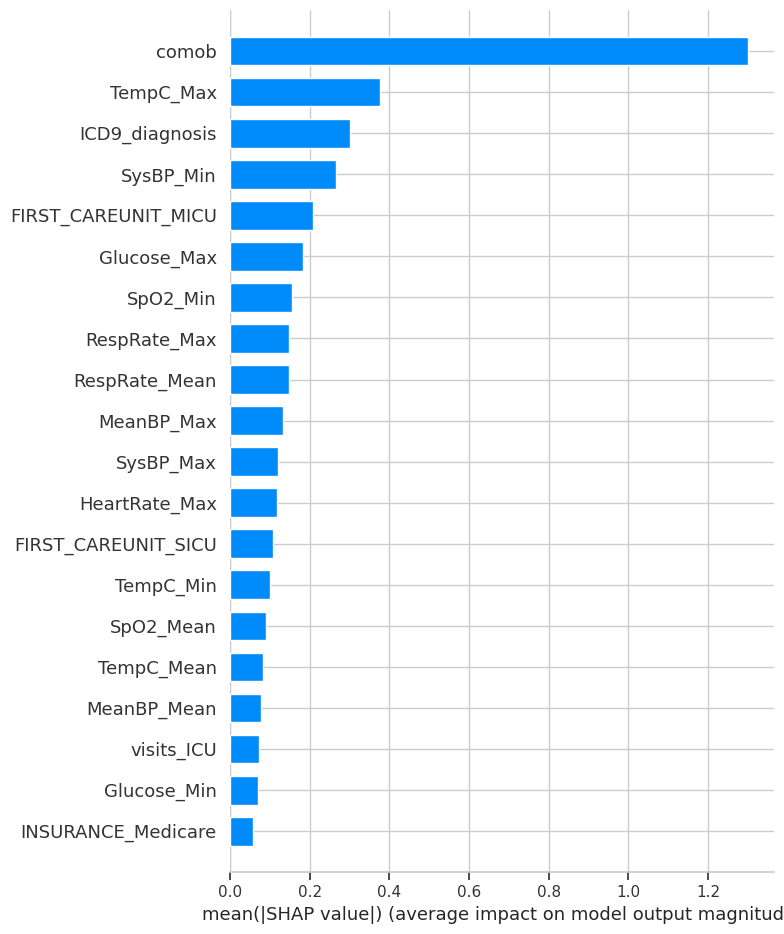

In [92]:
explainer = shap.TreeExplainer(Xgb) 
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

+ SHAP values represent the impact of each feature on the model's output. 
+ Positive SHAP values indicate that a feature increases the predicted value
+ In this case, we can see 'comob' and 'TempC_Max'  are the features with more impact in the prediction, specifically in the Length of Stay of the patient. 

In [93]:
# Plot the explanation of one observation
mytarget = 1#5

shap.initjs() ## needed to be added in each cell to get the plot to work

shap.force_plot(explainer.expected_value, shap_values[mytarget,:], X_test.iloc[mytarget,:])


In [94]:

# Create DataFrame
df_inter = pd.DataFrame(zip(X_test.columns,X_test.mean(),X_test.iloc[mytarget,:],shap_values[mytarget,:]), 
             columns=['feature','avg_value','mytarget_value','shap_value'])

# Sort by shap_value in descending order
df_sorted_desc = df_inter.sort_values(by='shap_value', ascending=False)

# Sort by shap_value in ascending order
df_sorted_asc = df_inter.sort_values(by='shap_value', ascending=True)

df_sorted_desc.head()

,feature,avg_value,mytarget_value,shap_value
16,TempC_Max,0.097749,2.235294,0.687805
17,TempC_Mean,0.030972,1.565789,0.650517
3,SysBP_Min,0.063279,-0.850000,0.415850
14,RespRate_Mean,0.134899,1.588949,0.373378
13,RespRate_Max,0.082020,1.625000,0.284945


In [95]:
df_sorted_asc.head()

,feature,avg_value,mytarget_value,shap_value
26,comob,0.070638,-0.300000,-1.749780
4,SysBP_Max,0.073936,-0.166667,-0.266735
18,SpO2_Min,-0.315945,0.250000,-0.181929
24,ICD9_diagnosis,3061.938002,-0.772889,-0.148143
23,Glucose_Mean,0.788352,5.997450,-0.124120
